In [2]:
from __future__ import print_function, division
import os, glob, argparse
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from scipy.ndimage import imread
import shutil
import time

In [3]:
class HangulDataset(Dataset):
    """Hangul Handwritten dataset."""

    def __init__(self, root_dir, subroot='char_data', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.subroot = subroot
        self.transform = transform
        self.classlist = os.listdir(os.path.join(root_dir, self.subroot))
        self.targets = []
        self.filenames = []
        self.targetdict = {}
        for i, label in enumerate(self.classlist):
            files = glob.glob(
                        os.path.join(self.root_dir, self.subroot, label) + '/*')
            self.filenames += files
            self.targets += [i] * len(files)
            self.targetdict[i] = int(label, 16)
            
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        target = self.targets[idx]
        sample = imread(img_name, mode='L')
        if self.transform:
            sample = self.transform(sample)
        return (sample, target)
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size, self.output_size),
                               mode='reflect')

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        maxval = img.max()
        blkidx = np.where(img > maxval*0.95)
        img[blkidx] = 0
        return img
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        dims = sample.shape
        if len(dims) == 2:
            image = np.expand_dims(sample, 0)
        else:
            image = sample.transpose((2, 0, 1))
        sampletensor = torch.from_numpy(image)
        return sampletensor.type(torch.FloatTensor)
    
class ObjectCrop(object):
    """Detect centre of character and crop unnecessary background"""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        h, w = sample.shape[:2]
        new_h, new_w = self.output_size
        # Get centre of character
        minval = sample.min()
        threshold = 0.1
        whiteidx = np.where(sample > minval*threshold)
        h_centre = whiteidx[0].mean().astype(int)
        w_centre = whiteidx[1].mean().astype(int)
        centrepixel = (h_centre, w_centre)

        h_start = h_centre - (new_h // 2)
        h_end = h_start + new_h
        w_start = w_centre - (new_w // 2)
        w_end = w_start + new_w

        if h_start < 0:   # If new index is less than 0
            h_start = 0
            h_end = new_h - 1
        elif h_end > h:   # If new index is larger than original height
            h_end = h
            h_start = h - new_h
        if w_start < 0:
            w_start = 0
            w_end = new_w - 1
        elif w_end > w:
            w_end = w
            w_start = w - new_w
            
        image = sample[h_start:h_end,
                      w_start:w_end]

        return image
    
class Stablize(object):
    """Stablize pixel values of images."""
    def __call__(self, sample):
        sample = -(sample / 255) + 1
        return sample
    
class Normalize(object):
    """Normalize images."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        return (sample - self.mean) / self.std

In [4]:
hangul_dataset = HangulDataset('set 01', transform=Stablize())
transformed_dataset = HangulDataset(root_dir='set 01',
                                    transform=transforms.Compose([
                                    Stablize(),
#                                     Normalize(0.027, 0.09),
                                    Rescale(256),
                                    ObjectCrop(224),
                                    ToTensor(),    
                                    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=100,
                        shuffle=True)

In [5]:
num_data = len(hangul_dataset)
mean = 0
for j in range(10):
    sampleidx = list(range(num_data))
    np.random.shuffle(sampleidx)
    samplemean = 0
    for i in sampleidx[:1000]:
        samplemean += np.mean(hangul_dataset[sampleidx[i]][0])
    samplemean = samplemean / 1000
    mean += samplemean
mean /= 10
print('mean: {}'.format(mean))

KeyboardInterrupt: 

In [8]:
sums = 0
for i in sampleidx[:1000]:
    sums += (hangul_dataset[sampleidx[i]][0] - mean).sum()**2
samplestd = np.sqrt(sums / (num_data-1))
print('sample std: {}'.format(samplestd))

sample std: 88.5860092324008


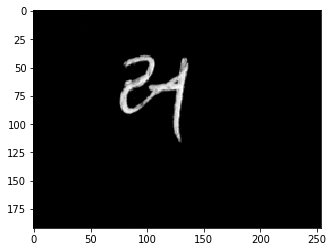

In [153]:
plt.imshow(hangul_dataset[100][0], cmap='gray')
plt.show()

In [191]:
import cv2

ImportError: dlopen(/Users/Joonil/anaconda/envs/pytorch/lib/python3.6/site-packages/cv2.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libtiff.5.dylib
  Referenced from: /Users/Joonil/anaconda/envs/pytorch/lib/libopencv_imgcodecs.3.3.dylib
  Reason: Incompatible library version: libopencv_imgcodecs.3.3.dylib requires version 9.0.0 or later, but libtiff.5.dylib provides version 8.0.0

In [192]:
!otool -L /Users/Joonil/anaconda/envs/pytorch/lib/libopencv_imgcodecs.3.3.dylib

/Users/Joonil/anaconda/envs/pytorch/lib/libopencv_imgcodecs.3.3.dylib:
	@rpath/libopencv_imgcodecs.3.3.dylib (compatibility version 3.3.0, current version 3.3.1)
	@rpath/libopencv_imgproc.3.3.dylib (compatibility version 3.3.0, current version 3.3.1)
	@rpath/libz.1.dylib (compatibility version 1.0.0, current version 1.2.11)
	@rpath/libjpeg.9.dylib (compatibility version 12.0.0, current version 12.0.0)
	@rpath/libpng16.16.dylib (compatibility version 49.0.0, current version 49.0.0)
	@rpath/libtiff.5.dylib (compatibility version 9.0.0, current version 9.0.0)
	@rpath/libjasper.1.dylib (compatibility version 2.0.0, current version 2.0.0)
	@rpath/libopencv_core.3.3.dylib (compatibility version 3.3.0, current version 3.3.1)
	@rpath/libc++.1.dylib (compatibility version 1.0.0, current version 1.0.0)
	/usr/lib/libSystem.B.dylib (compatibility version 1.0.0, current version 1197.1.1)


In [ ]:
cv2.fastNlMeansDenoising()

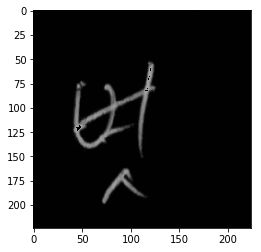

In [151]:
idx = int(np.random.rand(1)*len(transformed_dataset))
plt.imshow(transformed_dataset[idx][0].numpy().transpose(1,2,0))
plt.show()

In [105]:
def show_batch(sample_batched):
    """Show images for a batch of samples."""
    batch_size = len(sample_batched)
    im_size = sample_batched.size(2)

    grid = utils.make_grid(sample_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, (sample_batched, target_batched) in enumerate(dataloader):
    print(i_batch, sample_batched.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

RuntimeError: inconsistent tensor sizes at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/TH/generic/THTensorMath.c:2709

In [5]:
pretrained_model = models.vgg19_bn(pretrained=True)

In [8]:
# create custom VGG19_bn
num_classes = 2350
class CustomVGG19bn(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG19bn, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.features.children()))
        self.classifier = nn.Sequential(
            *[list(pretrained_model.classifier.children())[i] for i in range(6)],
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 25088)
        x = self.classifier(x)
        return x

# load custom model
model = CustomVGG19bn(num_classes=2350)

In [9]:
for param in model.parameters():
    param.requires_grad = False
for layer_idx, param in enumerate(model.classifier.parameters()):
    param.requires_grad = True

In [11]:
# unfrozen_weights = filter(lambda x: x.requires_grad, model.parameters())
# print(list(map(lambda x: x.size(), unfrozen_weights)))

[torch.Size([4096, 25088]), torch.Size([4096]), torch.Size([4096, 4096]), torch.Size([4096]), torch.Size([2350, 4096]), torch.Size([2350])]


In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs).float().cuda()
                    labels = Variable(labels).long().cuda()
                else:
                    inputs, labels = Variable(inputs).float(), Variable(labels).long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                # print every 10 iterations
                if (i+1) % 10 == 0:
                    print('Epoch: {0:}/{1:}, Iterations: {2:}/{3:}, Training loss: {4:6.2f}'.
                     format(epoch, num_epochs, i, len(dataloaders[phase]), loss.data[0]))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
# train, test data split
num_data = len(hangul_dataset.filenames)
indices = list(range(num_data))
np.random.seed(42)
np.random.shuffle(indices)

val_size = 0.20
test_size = 0.20
test_split = int(np.floor(test_size * num_data))
val_split = test_split + int(np.floor(val_size * num_data))
num_train = num_data - val_split - test_split
train_idx, val_idx, test_idx = indices[val_split:], indices[test_split:val_split] , indices[:test_split]

# Hyper Parameters
num_epochs = 1
batch_size = 100
learning_rate = 0.0001

 # Define sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Train, test dataset loader
train_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=train_sampler)

val_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=val_sampler)

test_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=test_sampler)

dataloaders = {'train':train_loader, 'val':val_loader, 'test':test_loader}

 # use gpu if cuda is available
use_gpu = torch.cuda.is_available()

if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/0
----------


KeyboardInterrupt: 